# About Dataset
The generated fake reviews dataset, containing 20k fake reviews and 20k real product reviews. OR = Original reviews (presumably human created and authentic); CG = Computer-generated fake reviews.

In [ ]:
import pandas as pd
pd.set_option("display.max_columns",None)

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier



from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,classification_report,precision_recall_fscore_support

In [ ]:
df = pd.read_csv("fake reviews dataset.csv")
df["label"] = df["label"].map({
    "CG":"Fake",
    "OR":"Original"
})

In [ ]:
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,Fake,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,Fake,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,Fake,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,Fake,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,Fake,Very nice set. Good quality. We have had the s...


# Exploratory Data Analytics

In [ ]:
data_info = {
    "Shape": df.shape,
    "Columns": df.columns.tolist(),
    "Missing Values": df.isnull().sum().to_dict(),
    "Duplicate Rows": df.duplicated().sum(),
    "Sample Data": df.head().to_dict()
}

data_info

{'Shape': (40432, 4),
 'Columns': ['category', 'rating', 'label', 'text_'],
 'Missing Values': {'category': 0, 'rating': 0, 'label': 0, 'text_': 0},
 'Duplicate Rows': 12,
 'Sample Data': {'category': {0: 'Home_and_Kitchen_5',
   1: 'Home_and_Kitchen_5',
   2: 'Home_and_Kitchen_5',
   3: 'Home_and_Kitchen_5',
   4: 'Home_and_Kitchen_5'},
  'rating': {0: 5.0, 1: 5.0, 2: 5.0, 3: 1.0, 4: 5.0},
  'label': {0: 'Fake', 1: 'Fake', 2: 'Fake', 3: 'Fake', 4: 'Fake'},
  'text_': {0: 'Love this!  Well made, sturdy, and very comfortable.  I love it!Very pretty',
   1: "love it, a great upgrade from the original.  I've had mine for a couple of years",
   2: 'This pillow saved my back. I love the look and feel of this pillow.',
   3: 'Missing information on how to use it, but it is a great product for the price!  I',
   4: 'Very nice set. Good quality. We have had the set for two months now and have not been'}}}

In [ ]:
# Remove duplicates
data_cleaned = df.drop_duplicates()

# Check the distribution of the 'label' column
label_distribution = data_cleaned['label'].value_counts()

# Display the cleaned dataset shape and label distribution
cleaned_info = {
    "Cleaned Shape": data_cleaned.shape,
    "Label Distribution": label_distribution.to_dict()
}

cleaned_info

{'Cleaned Shape': (40420, 4),
 'Label Distribution': {'Original': 20215, 'Fake': 20205}}

C:\Users\PC\AppData\Local\Temp\ipykernel_29792\3904135667.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['text_length'] = data_cleaned['text_'].apply(len)


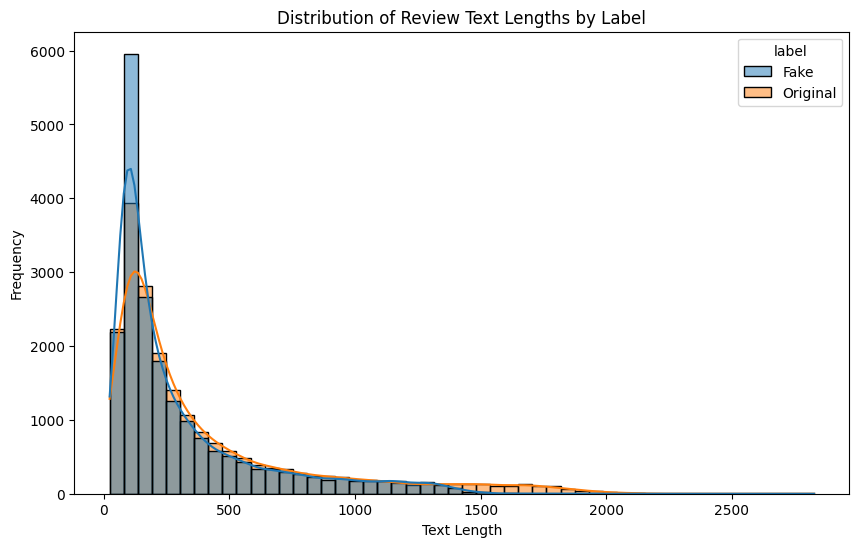

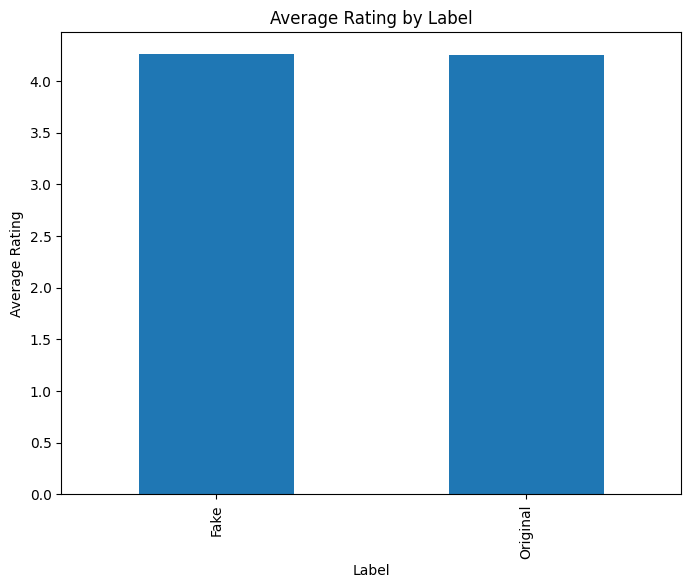

C:\Users\PC\AppData\Local\Temp\ipykernel_29792\3904135667.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['unique_word_count'] = data_cleaned['text_'].apply(lambda x: len(set(x.split())))


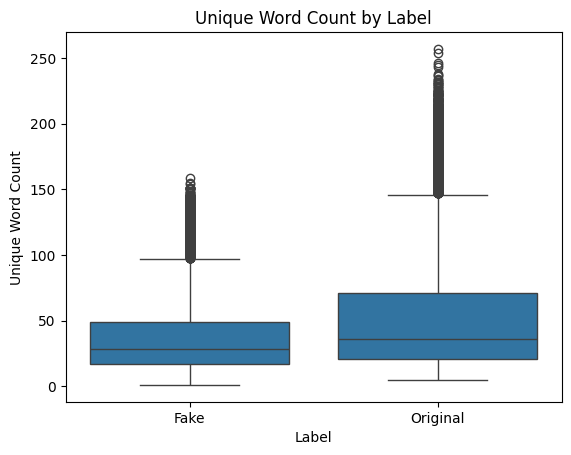

In [ ]:
# Add a column for text length
data_cleaned['text_length'] = data_cleaned['text_'].apply(len)

# Plot distribution of text lengths for each label
plt.figure(figsize=(10, 6))
sns.histplot(data=data_cleaned, x='text_length', hue='label', kde=True, bins=50)
plt.title('Distribution of Review Text Lengths by Label')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Analyze the average rating by label
average_rating = data_cleaned.groupby('label')['rating'].mean()

# Display average rating differences
average_rating.plot(kind='bar', figsize=(8, 6), title="Average Rating by Label")
plt.ylabel('Average Rating')
plt.xlabel('Label')
plt.show()

# Display unique words count in text by label
data_cleaned['unique_word_count'] = data_cleaned['text_'].apply(lambda x: len(set(x.split())))
sns.boxplot(data=data_cleaned, x='label', y='unique_word_count')
plt.title('Unique Word Count by Label')
plt.xlabel('Label')
plt.ylabel('Unique Word Count')
plt.show()

1. Review fake memiliki panjang text yang lebih pendek dibandingkan dengan review yang original.
2. Rata rata rating hampir sama antara review fake dan review yang original.
3. Review fake memiliki kata unique yang lebih sedikit dibandingkan dengan review original.
   

# Preprocessing

Steps:
- Text normalization (lowercasing, removing special characters, etc.).
- Tokenisasi.
- Stopword removal.

In [ ]:
# Define stopwords
stop_words = set(stopwords.words('english'))


# Text preprocessing function
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Removing special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Stopword removal
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to the text column
data_cleaned['text_preprocessed'] = data_cleaned['text_'].apply(preprocess_text)

C:\Users\PC\AppData\Local\Temp\ipykernel_29792\718247619.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['text_preprocessed'] = data_cleaned['text_'].apply(preprocess_text)


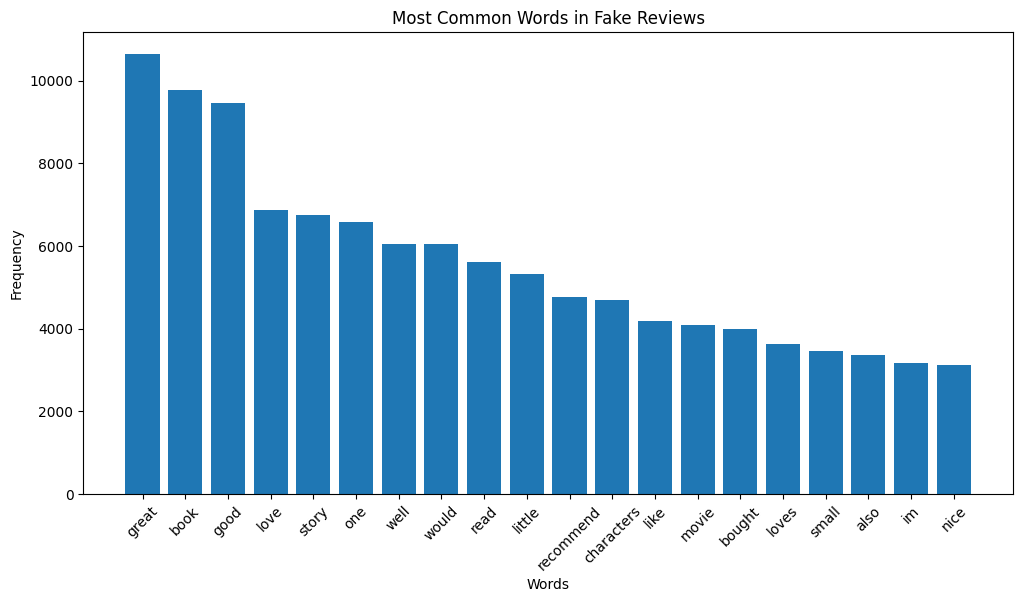

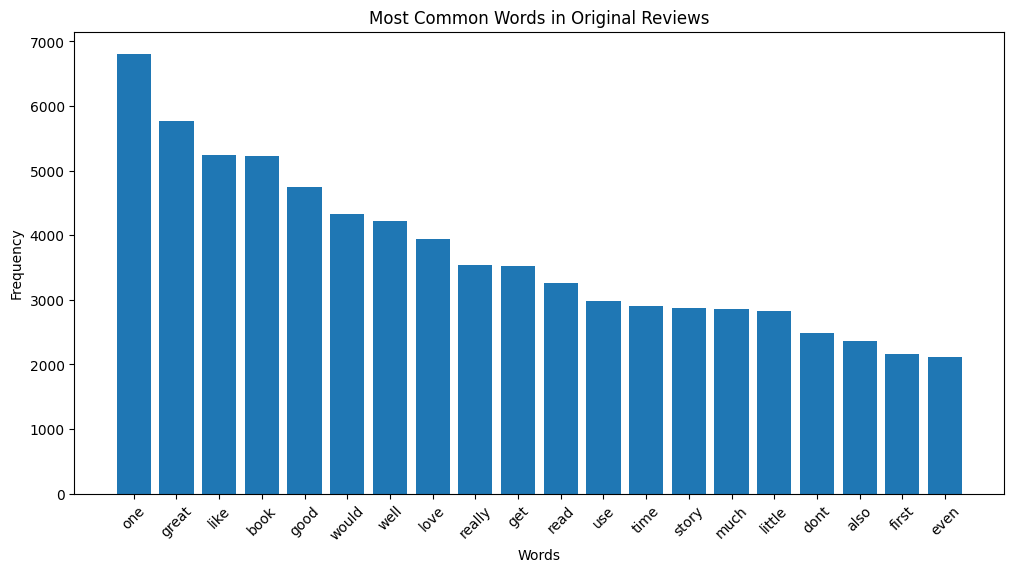

In [ ]:
# Separate fake and original reviews
fake_reviews = data_cleaned[data_cleaned['label'] == 'Fake']['text_preprocessed']
original_reviews = data_cleaned[data_cleaned['label'] == 'Original']['text_preprocessed']

# Count word frequencies
fake_word_counts = Counter(" ".join(fake_reviews).split())
original_word_counts = Counter(" ".join(original_reviews).split())

# Get the most common words for each category
fake_most_common = fake_word_counts.most_common(20)
original_most_common = original_word_counts.most_common(20)

# Plot the most common words for fake reviews
fake_words, fake_counts = zip(*fake_most_common)
plt.figure(figsize=(12, 6))
plt.bar(fake_words, fake_counts)
plt.title('Most Common Words in Fake Reviews')
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

# Plot the most common words for original reviews
original_words, original_counts = zip(*original_most_common)
plt.figure(figsize=(12, 6))
plt.bar(original_words, original_counts)
plt.title('Most Common Words in Original Reviews')
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

Terdapat pattern bahwa, fake reviews cenderung menggunakan kata kata positive sedangkan original lebih general dalam penggunaan kata katanya

# Training Model

Steps:
1. Extract text menggunakan TF-IDF
2. Training model
3. Evaluasi model

In [ ]:
data_cleaned["label"] = data_cleaned["label"].map({
    "Original":0,
    "Fake":1
})

data_cleaned["label"].unique()

C:\Users\PC\AppData\Local\Temp\ipykernel_29792\3298663478.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned["label"] = data_cleaned["label"].map({


array([1, 0], dtype=int64)

In [ ]:
# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = tfidf_vectorizer.fit_transform(data_cleaned['text_preprocessed'])
y = data_cleaned['label']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Initialize models
log_reg = LogisticRegression(max_iter=1000, random_state=42)
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(max_depth=5, random_state=42)
dt = DecisionTreeClassifier(random_state=42, max_depth=5)

# Train models and evaluate
results = {}

for model, name in zip(
    [log_reg, random_forest, xgb, dt],
    ["Logistic Regression", "Random Forest", "XGBoost", "Decision Tree"]
):
    model.fit(X_train, y_train)

    # Training predictions
    y_train_pred = model.predict(X_train)
    y_train_prob = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else None
    y_train_auc = roc_auc_score(y_train, y_train_prob) if y_train_prob is not None else None

    # Testing predictions
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    y_test_auc = roc_auc_score(y_test, y_test_prob) if y_test_prob is not None else None

    # Store results
    results[name] = {
        "Train Accuracy": accuracy_score(y_train, y_train_pred),
        "Test Accuracy": accuracy_score(y_test, y_test_pred),
        "Train Precision": classification_report(y_train, y_train_pred, output_dict=True)['weighted avg']['precision'],
        "Test Precision": classification_report(y_test, y_test_pred, output_dict=True)['weighted avg']['precision'],
        "Train Recall": classification_report(y_train, y_train_pred, output_dict=True)['weighted avg']['recall'],
        "Test Recall": classification_report(y_test, y_test_pred, output_dict=True)['weighted avg']['recall'],
        "Train F1-Score": classification_report(y_train, y_train_pred, output_dict=True)['weighted avg']['f1-score'],
        "Test F1-Score": classification_report(y_test, y_test_pred, output_dict=True)['weighted avg']['f1-score'],
        "Train ROC AUC": y_train_auc,
        "Test ROC AUC": y_test_auc
    }

dataframe=pd.DataFrame(results).T
dataframe

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1-Score,Test F1-Score,Train ROC AUC,Test ROC AUC
Logistic Regression,0.916409,0.895720,0.916498,0.895733,0.916409,0.895720,0.916404,0.895719,0.974229,0.961796
Random Forest,0.999876,0.858238,0.999876,0.858432,0.999876,0.858238,0.999876,0.858219,1.000000,0.935275
XGBoost,0.878556,0.841539,0.880100,0.842675,0.878556,0.841539,0.878432,0.841406,0.957161,0.928443
Decision Tree,0.587735,0.581395,0.690873,0.672218,0.587735,0.581395,0.523261,0.517733,0.648961,0.636626


# Deeplearning

## DNN

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

# Prepare the data for deep learning
max_vocab_size = 10000  # Vocabulary size
max_sequence_length = 100  # Maximum length of input sequences

# Tokenize the text data
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(data_cleaned['text_preprocessed'])

# Convert text to sequences
X = tokenizer.texts_to_sequences(data_cleaned['text_preprocessed'])
X = pad_sequences(X, maxlen=max_sequence_length, padding='post', truncating='post')

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data_cleaned['label'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Build the DNN model
dnn_model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=128, input_length=max_sequence_length),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
dnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = dnn_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

# Evaluate the model
train_loss, train_accuracy = dnn_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = dnn_model.evaluate(X_test, y_test, verbose=0)

# Results
deep_learning_results = {
    "Train Accuracy": train_accuracy,
    "Test Accuracy": test_accuracy,
    "Train Loss": train_loss,
    "Test Loss": test_loss
}

deep_learning_results


Epoch 1/5


c:\Users\PC\anaconda3\envs\deeplearning\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


405/405 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6977 - loss: 0.5517 - val_accuracy: 0.8595 - val_loss: 0.3364
Epoch 2/5
405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8501 - loss: 0.3223 - val_accuracy: 0.8695 - val_loss: 0.2989
Epoch 3/5
405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8753 - loss: 0.2736 - val_accuracy: 0.8819 - val_loss: 0.2831
Epoch 4/5
405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9037 - loss: 0.2261 - val_accuracy: 0.8802 - val_loss: 0.2837
Epoch 5/5
405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9156 - loss: 0.1993 - val_accuracy: 0.8517 - val_loss: 0.3519


{'Train Accuracy': 0.8787729144096375,
 'Test Accuracy': 0.8581147789955139,
 'Train Loss': 0.26716503500938416,
 'Test Loss': 0.33116644620895386}

In [ ]:
# Predictions for training and testing data
y_train_pred = (dnn_model.predict(X_train) > 0.5).astype("int32").flatten()
y_test_pred = (dnn_model.predict(X_test) > 0.5).astype("int32").flatten()

# Calculate metrics for training
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
    y_train, y_train_pred, average='binary'
)
train_roc_auc = roc_auc_score(y_train, dnn_model.predict(X_train))

# Calculate metrics for testing
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
    y_test, y_test_pred, average='binary'
)
test_roc_auc = roc_auc_score(y_test, dnn_model.predict(X_test))

# Combine results
deep_learning_metrics = {
    "Train Accuracy": train_accuracy,
    "Test Accuracy": test_accuracy,
    "Train Precision": train_precision,
    "Test Precision": test_precision,
    "Train Recall": train_recall,
    "Test Recall": test_recall,
    "Train F1-Score": train_f1,
    "Test F1-Score": test_f1,
    "Train ROC AUC": train_roc_auc,
    "Test ROC AUC": test_roc_auc
}

# Display results
display(pd.DataFrame([deep_learning_metrics]))


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 1s 872us/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 1s 859us/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step


,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1-Score,Test F1-Score,Train ROC AUC,Test ROC AUC
0,0.878773,0.858115,0.977759,0.957044,0.775118,0.749814,0.864725,0.840849,0.978549,0.960531


## LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, GlobalAveragePooling1D, Dense,Dropout
from tensorflow.keras.optimizers import Adam

# Build the LSTM model
lstm_model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=128, input_length=max_sequence_length),
    Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.2)),
    Dropout(0.2),
    LSTM(32),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the LSTM model
lstm_model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Train the LSTM model
history_lstm = lstm_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

# Evaluate the LSTM model
train_loss_lstm, train_accuracy_lstm = lstm_model.evaluate(X_train, y_train, verbose=0)
test_loss_lstm, test_accuracy_lstm = lstm_model.evaluate(X_test, y_test, verbose=0)

# Predictions for training and testing data
y_train_pred = (lstm_model.predict(X_train) > 0.5).astype("int32").flatten()
y_test_pred = (lstm_model.predict(X_test) > 0.5).astype("int32").flatten()

# Calculate metrics for training
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
    y_train, y_train_pred, average='binary'
)
train_roc_auc = roc_auc_score(y_train, lstm_model.predict(X_train))

# Calculate metrics for testing
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
    y_test, y_test_pred, average='binary'
)
test_roc_auc = roc_auc_score(y_test, lstm_model.predict(X_test))

# Combine results
lstm_metrics = {
    "Train Accuracy": train_accuracy_lstm,
    "Test Accuracy": test_accuracy_lstm,
    "Train Precision": train_precision,
    "Test Precision": test_precision,
    "Train Recall": train_recall,
    "Test Recall": test_recall,
    "Train F1-Score": train_f1,
    "Test F1-Score": test_f1,
    "Train ROC AUC": train_roc_auc,
    "Test ROC AUC": test_roc_auc
}

# Display results
display(pd.DataFrame([lstm_metrics]))

Epoch 1/5


c:\Users\PC\anaconda3\envs\deeplearning\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


405/405 ━━━━━━━━━━━━━━━━━━━━ 36s 80ms/step - accuracy: 0.5474 - loss: 0.6725 - val_accuracy: 0.7079 - val_loss: 0.5652
Epoch 2/5
405/405 ━━━━━━━━━━━━━━━━━━━━ 32s 78ms/step - accuracy: 0.7279 - loss: 0.5260 - val_accuracy: 0.8115 - val_loss: 0.4366
Epoch 3/5
405/405 ━━━━━━━━━━━━━━━━━━━━ 32s 79ms/step - accuracy: 0.8423 - loss: 0.3749 - val_accuracy: 0.8862 - val_loss: 0.2675
Epoch 4/5
405/405 ━━━━━━━━━━━━━━━━━━━━ 34s 83ms/step - accuracy: 0.9151 - loss: 0.2107 - val_accuracy: 0.8998 - val_loss: 0.2473
Epoch 5/5
405/405 ━━━━━━━━━━━━━━━━━━━━ 33s 81ms/step - accuracy: 0.9488 - loss: 0.1390 - val_accuracy: 0.9054 - val_loss: 0.2593
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1-Score,Test F1-Score,Train ROC AUC,Test ROC AUC
0,0.953643,0.914523,0.964641,0.928608,0.941784,0.898045,0.953076,0.913071,0.989598,0.97384
